<a href="https://colab.research.google.com/github/ryanpereirax/Intrusion-detector-with-supervised-models/blob/main/gear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
gear_df = pd.read_csv('/content/gear_dataset.csv')


In [ ]:
# Amostras de 1% do Dataset Original
amostras_R = gear_df[gear_df['R'] == 'R'].sample(n=5_000, random_state=42)
amostras_T = gear_df[gear_df['R'] == 'T'].sample(n=4_000, random_state=42)
gear_df_balanceado = pd.concat([amostras_R, amostras_T]).sample(frac=1, random_state=42).reset_index(drop=True)

gear_df_balanceado.to_csv('gear_df_proporcional_ajustado.csv', index=False)

In [ ]:
pip install xgboost catboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Carregar o arquivo para examinar os dados
file_path = "/content/gear_df_proporcional_ajustado.csv"
data = pd.read_csv(file_path)

# Verificar as primeiras linhas do dataset para compreender sua estrutura
data.head()


,1478193190.056566,0140,8,00,00.1,00.2,00.3,10,29,2a,24,R
0,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
1,1.478193e+09,0370,8,00,20,00,00,00,00,00,00,R
2,1.478193e+09,0140,8,00,00,00,00,0c,23,21,3b,R
3,1.478193e+09,0350,8,05,20,f4,68,77,00,00,ce,R
4,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T


In [ ]:
# Renomear as colunas para melhor compreensão
data.columns = ['Timestamp', 'CAN_ID', 'DLC', 'DATA_0', 'DATA_1', 'DATA_2',
                'DATA_3', 'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7', 'Flag']

# Verificar se existem valores ausentes
missing_data = data.isnull().sum()

# Analisar a proporção de flags 'T' e 'R'
flag_distribution = data['Flag'].value_counts(normalize=True)

# Examinar estatísticas descritivas para colunas numéricas
numeric_stats = data.describe()

missing_data, flag_distribution, numeric_stats


(Timestamp    0
 CAN_ID       0
 DLC          0
 DATA_0       0
 DATA_1       0
 DATA_2       0
 DATA_3       0
 DATA_4       0
 DATA_5       0
 DATA_6       0
 DATA_7       0
 Flag         0
 dtype: int64,
 Flag
 R    0.555556
 T    0.444444
 Name: proportion, dtype: float64,
           Timestamp     DLC
 count  9.000000e+03  9000.0
 mean   1.478193e+09     8.0
 std    1.001928e+02     0.0
 min    1.478193e+09     8.0
 25%    1.478193e+09     8.0
 50%    1.478193e+09     8.0
 75%    1.478193e+09     8.0
 max    1.478194e+09     8.0)

In [ ]:
# Converter o Timestamp para um formato de data legível para análise temporal
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')

# Criar uma nova coluna para armazenar apenas a hora das mensagens
data['Hour'] = data['Timestamp'].dt.hour

# Contar o número de mensagens por hora
messages_per_hour = data.groupby('Hour').size()

# Identificar quais CAN_IDs são mais frequentes
can_id_distribution = data['CAN_ID'].value_counts().head(10)

messages_per_hour, can_id_distribution


(Hour
 17    9000
 dtype: int64,
 CAN_ID
 043f    4266
 0002     295
 0440     295
 02a0     287
 0316     283
 0153     281
 0370     279
 0260     276
 018f     275
 02c0     267
 Name: count, dtype: int64)

In [ ]:
# Verificar a distribuição dos CAN_IDs em relação às flags 'T' e 'R'
can_id_flag_distribution = data.groupby(['CAN_ID', 'Flag']).size().unstack(fill_value=0)

# Explorar padrões nos campos 'DATA_X' para mensagens com flag 'T'
data_injected = data[data['Flag'] == 'T']
data_normal = data[data['Flag'] == 'R']

# Calcular estatísticas descritivas para os campos 'DATA_X' para cada tipo de flag
data_injected_stats = data_injected[['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3',
                                     'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']].describe()

data_normal_stats = data_normal[['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3',
                                 'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']].describe()

can_id_flag_distribution, data_injected_stats, data_normal_stats


(Flag      R     T
 CAN_ID           
 0002    295     0
 00a0     32     0
 00a1     27     0
 0130    257     0
 0131    253     0
 0140    265     0
 0153    281     0
 018f    275     0
 01f1    145     0
 0260    276     0
 02a0    287     0
 02c0    267     0
 0316    283     0
 0329    264     0
 0350    235     0
 0370    279     0
 0430    134     0
 043f    266  4000
 0440    295     0
 04b1    163     0
 04f0    126     0
 0545    266     0
 05a0      5     0
 05a2      3     0
 0690     21     0,
        DATA_0 DATA_1 DATA_2 DATA_3 DATA_4 DATA_5 DATA_6 DATA_7
 count    4000   4000   4000   4000   4000   4000   4000   4000
 unique      1      1      1      1      1      1      1      1
 top        01     45     60     ff     6b     00     00     00
 freq     4000   4000   4000   4000   4000   4000   4000   4000,
        DATA_0 DATA_1 DATA_2 DATA_3 DATA_4 DATA_5 DATA_6 DATA_7
 count    5000   5000   5000   5000   5000   5000   5000   5000
 unique     90    107     87     31  

In [ ]:
# Verificar a distribuição temporal das mensagens com CAN_ID '0000' (flag 'T')
injected_id_0000 = data[(data['CAN_ID'] == '0000') & (data['Flag'] == 'T')]

# Contagem de mensagens injetadas por minuto
injected_id_0000['Minute'] = injected_id_0000['Timestamp'].dt.minute
injected_per_minute = injected_id_0000.groupby('Minute').size()

# Explorar CAN_IDs que aparecem menos frequentemente para identificar possíveis outliers
rare_can_ids = data['CAN_ID'].value_counts().tail(10)

# Verificar se existem correlações entre os campos 'DATA_X' para as mensagens normais
data_normal_numeric = data_normal[['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3',
                                   'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']].apply(lambda x: x.apply(int, base=16))
correlation_matrix = data_normal_numeric.corr()

injected_per_minute, rare_can_ids, correlation_matrix


(Series([], dtype: int64),
 CAN_ID
 0350    235
 04b1    163
 01f1    145
 0430    134
 04f0    126
 00a0     32
 00a1     27
 0690     21
 05a0      5
 05a2      3
 Name: count, dtype: int64,
           DATA_0    DATA_1    DATA_2    DATA_3    DATA_4    DATA_5    DATA_6  \
 DATA_0  1.000000  0.184716 -0.167214 -0.168606  0.307370  0.040807 -0.142517   
 DATA_1  0.184716  1.000000  0.187297  0.213315 -0.119309  0.234809 -0.259627   
 DATA_2 -0.167214  0.187297  1.000000  0.049786  0.284923 -0.150008  0.236163   
 DATA_3 -0.168606  0.213315  0.049786  1.000000  0.038713  0.555471 -0.028547   
 DATA_4  0.307370 -0.119309  0.284923  0.038713  1.000000  0.071258  0.191398   
 DATA_5  0.040807  0.234809 -0.150008  0.555471  0.071258  1.000000  0.024941   
 DATA_6 -0.142517 -0.259627  0.236163 -0.028547  0.191398  0.024941  1.000000   
 DATA_7 -0.237829  0.121441  0.118893 -0.024923 -0.055992 -0.037717 -0.111179   
 
           DATA_7  
 DATA_0 -0.237829  
 DATA_1  0.121441  
 DATA_2  0.11889

In [ ]:
# Converter os campos 'DATA_X' para valores numéricos para análise de correlação
data_numeric = data[['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3',
                     'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']].apply(lambda x: x.apply(int, base=16))

# Adicionar a flag como numérica (T = 1, R = 0) para facilitar a análise
data_numeric['Flag'] = data['Flag'].apply(lambda x: 1 if x == 'T' else 0)

# Calcular a correlação entre os campos de dados e a flag
correlation_with_flag = data_numeric.corr()['Flag'].drop('Flag')

correlation_with_flag


,Flag
DATA_0,-0.387504
DATA_1,0.316027
DATA_2,0.517288
DATA_3,0.809873
DATA_4,0.501528
DATA_5,-0.463789
DATA_6,-0.295690
DATA_7,-0.388333


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)
from sklearn.decomposition import PCA

# Supondo que 'data_numeric' esteja carregado corretamente
X = data_numeric.drop(['Flag','DATA_0', 'DATA_1', 'DATA_2', 'DATA_4', 'DATA_5', 'DATA_7'], axis=1)  # Features
y = data_numeric['Flag']  # Rótulo

# Dividindo os dados em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Aplicando o MinMaxScaler nos conjuntos de treino, validação e teste
scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

# Aplicando o PCA com variação acumulada de 95%
pca = PCA(n_components=0.95)  # Retém 95% da variância
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Ajustando o PCA apenas nos dados de treino e transformando nos demais
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Criando o modelo de Regressão Logística
model_minmax = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    max_iter=500,
    random_state=42
)

# Treinando o modelo com os dados de treino transformados pelo PCA
model_minmax.fit(X_train_pca, y_train)

# Função para calcular e exibir métricas
def print_metrics(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))

# Avaliando no conjunto de treino
y_train_pred = model_minmax.predict(X_train_pca)
y_train_prob = model_minmax.predict_proba(X_train_pca)[:, 1]
print_metrics(y_train, y_train_pred, y_train_prob, "Treino")

# Avaliando no conjunto de validação
y_val_pred = model_minmax.predict(X_val_pca)
y_val_prob = model_minmax.predict_proba(X_val_pca)[:, 1]
print_metrics(y_val, y_val_pred, y_val_prob, "Validação")

# Avaliando no conjunto de teste
y_test_pred = model_minmax.predict(X_test_pca)
y_test_prob = model_minmax.predict_proba(X_test_pca)[:, 1]
print_metrics(y_test, y_test_pred, y_test_prob, "Teste")


Métricas para o conjunto de Treino:
Acurácia: 0.9124
Precisão: 0.8371
Recall: 1.0000
F1-Score: 0.9113
AUC-ROC: 0.9699

Matriz de Confusão:
[[2497  473]
 [   0 2430]]

Métricas para o conjunto de Validação:
Acurácia: 0.9183
Precisão: 0.8409
Recall: 1.0000
F1-Score: 0.9136
AUC-ROC: 0.9761

Matriz de Confusão:
[[876 147]
 [  0 777]]

Métricas para o conjunto de Teste:
Acurácia: 0.8978
Precisão: 0.8117
Recall: 1.0000
F1-Score: 0.8960
AUC-ROC: 0.9662

Matriz de Confusão:
[[823 184]
 [  0 793]]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)
from sklearn.decomposition import PCA

# Supondo que 'data_numeric' esteja carregado corretamente
X = data_numeric.drop(['Flag','DATA_0', 'DATA_1', 'DATA_2', 'DATA_4', 'DATA_5', 'DATA_7'], axis=1)  # Features
y = data_numeric['Flag']  # Rótulo

# Dividindo os dados em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Aplicando o MinMaxScaler
scaler_minmax = MinMaxScaler()
X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

# Aplicando o PCA com variação acumulada de 95%
pca = PCA(n_components=0.95)  # Retém 95% da variância
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Ajustando o modelo Random Forest para reduzir overfitting
model_rf = RandomForestClassifier(
    n_estimators=200,  # Aumentar o número de árvores para maior estabilidade
    max_depth=8,  # Reduzindo a profundidade máxima para evitar overfitting
    min_samples_split=10,  # Maior número de amostras para dividir
    min_samples_leaf=5,  # Mais amostras por folha para regularizar
    random_state=42,
    n_jobs=-1
)

# Treinando o modelo com os dados de treino transformados pelo PCA
model_rf.fit(X_train_pca, y_train)

# Função para calcular e exibir métricas
def print_metrics_rf(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))

# Avaliando no conjunto de treino
y_train_pred_rf = model_rf.predict(X_train_pca)
y_train_prob_rf = model_rf.predict_proba(X_train_pca)[:, 1]
print_metrics(y_train, y_train_pred_rf, y_train_prob_rf, "Treino")

# Avaliando no conjunto de validação
y_val_pred_rf = model_rf.predict(X_val_pca)
y_val_prob_rf = model_rf.predict_proba(X_val_pca)[:, 1]
print_metrics(y_val, y_val_pred_rf, y_val_prob_rf, "Validação")

# Avaliando no conjunto de teste
y_test_pred_rf = model_rf.predict(X_test_pca)
y_test_prob_rf = model_rf.predict_proba(X_test_pca)[:, 1]
print_metrics_rf(y_test, y_test_pred_rf, y_test_prob_rf, "Teste")



Métricas para o conjunto de Treino:
Acurácia: 0.9669
Precisão: 0.9314
Recall: 1.0000
F1-Score: 0.9645
AUC-ROC: 0.9699

Matriz de Confusão:
[[2791  179]
 [   0 2430]]

Métricas para o conjunto de Validação:
Acurácia: 0.9728
Precisão: 0.9407
Recall: 1.0000
F1-Score: 0.9694
AUC-ROC: 0.9761

Matriz de Confusão:
[[974  49]
 [  0 777]]

Métricas para o conjunto de Teste:
Acurácia: 0.9622
Precisão: 0.9210
Recall: 1.0000
F1-Score: 0.9589
AUC-ROC: 0.9662

Matriz de Confusão:
[[939  68]
 [  0 793]]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)
from sklearn.decomposition import PCA

# Supondo que 'data_numeric' esteja carregado corretamente
X = data_numeric.drop(['Flag','DATA_0', 'DATA_1', 'DATA_2', 'DATA_4', 'DATA_5', 'DATA_7'], axis=1)  # Features
y = data_numeric['Flag']  # Rótulo

# Dividindo os dados em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Aplicando o MinMaxScaler nos conjuntos de treino, validação e teste
scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

# Aplicando o PCA com variação acumulada de 95%
pca = PCA(n_components=0.95)  # Retém 95% da variância
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Criando e treinando o modelo de Árvore de Decisão com regularização
model_tree = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

model_tree.fit(X_train_pca, y_train)

# Função para calcular e exibir métricas
def print_metrics_tree(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))


# Função para calcular e exibir métricas
def print_metrics_tree(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))

# Avaliando no conjunto de treino
y_train_pred_tree = model_tree.predict(X_train_pca)
y_train_prob_tree = model_tree.predict_proba(X_train_pca)[:, 1]
print_metrics_tree(y_train, y_train_pred_tree, y_train_prob_tree, "Treino")

# Avaliando no conjunto de teste
y_test_pred_tree = model_tree.predict(X_test_pca)
y_test_prob_tree = model_rf.predict_proba(X_test_pca)[:, 1]
print_metrics_tree(y_test, y_test_pred_tree, y_test_prob_tree, "Teste")

# Avaliando no conjunto de validação
y_val_pred_tree = model_tree.predict(X_val_pca)
y_val_prob_tree = model_tree.predict_proba(X_val_pca)[:, 1]
print_metrics_tree(y_val, y_val_pred_tree, y_val_prob_tree, "Validação")



Métricas para o conjunto de Treino:
Acurácia: 0.9669
Precisão: 0.9314
Recall: 1.0000
F1-Score: 0.9645
AUC-ROC: 0.9699

Matriz de Confusão:
[[2791  179]
 [   0 2430]]

Métricas para o conjunto de Teste:
Acurácia: 0.9622
Precisão: 0.9210
Recall: 1.0000
F1-Score: 0.9589
AUC-ROC: 0.9662

Matriz de Confusão:
[[939  68]
 [  0 793]]

Métricas para o conjunto de Validação:
Acurácia: 0.9728
Precisão: 0.9407
Recall: 1.0000
F1-Score: 0.9694
AUC-ROC: 0.9761

Matriz de Confusão:
[[974  49]
 [  0 777]]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)
from sklearn.decomposition import PCA

# Supondo que 'data_numeric' esteja carregado corretamente
X = data_numeric.drop(['Flag','DATA_0', 'DATA_1', 'DATA_2', 'DATA_4', 'DATA_5', 'DATA_7'], axis=1)  # Features
y = data_numeric['Flag']  # Rótulo

# Dividindo os dados em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Aplicando o MinMaxScaler nos conjuntos de treino, validação e teste
scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

# Aplicando o PCA com variação acumulada de 95%
pca = PCA(n_components=0.95)  # Retém 95% da variância
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Criando e treinando o modelo de Gradient Boosting
model_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

model_gb.fit(X_train_pca, y_train)

# Função para calcular e exibir métricas
def print_metrics_gb(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))

# Avaliando no conjunto de treino
y_train_pred_gb = model_gb.predict(X_train_pca)
y_train_prob_gb = model_gb.predict_proba(X_train_pca)[:, 1]
print_metrics_gb(y_train, y_train_pred_gb, y_train_prob_gb, "Treino")

# Avaliando no conjunto de teste
y_test_pred_gb = model_gb.predict(X_test_pca)
y_test_prob_gb = model_gb.predict_proba(X_test_pca)[:, 1]
print_metrics_gb(y_test, y_test_pred_gb, y_test_prob_gb, "Teste")

# Avaliando no conjunto de validação
y_val_pred_gb = model_gb.predict(X_val_pca)
y_val_prob_gb = model_gb.predict_proba(X_val_pca)[:, 1]
print_metrics_gb(y_val, y_val_pred_gb, y_val_prob_gb, "Validação")


Métricas para o conjunto de Treino:
Acurácia: 0.9669
Precisão: 0.9314
Recall: 1.0000
F1-Score: 0.9645
AUC-ROC: 0.9699

Matriz de Confusão:
[[2791  179]
 [   0 2430]]

Métricas para o conjunto de Teste:
Acurácia: 0.9622
Precisão: 0.9210
Recall: 1.0000
F1-Score: 0.9589
AUC-ROC: 0.9662

Matriz de Confusão:
[[939  68]
 [  0 793]]

Métricas para o conjunto de Validação:
Acurácia: 0.9728
Precisão: 0.9407
Recall: 1.0000
F1-Score: 0.9694
AUC-ROC: 0.9761

Matriz de Confusão:
[[974  49]
 [  0 777]]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)
from sklearn.decomposition import PCA

# Supondo que 'data_numeric' esteja carregado corretamente
X = data_numeric.drop(['Flag','DATA_0', 'DATA_1', 'DATA_2', 'DATA_4', 'DATA_5', 'DATA_7'], axis=1)  # Features
y = data_numeric['Flag']  # Rótulo

# Dividindo os dados em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Aplicando o MinMaxScaler nos conjuntos de treino, validação e teste
scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

# Aplicando o PCA com variação acumulada de 95%
pca = PCA(n_components=0.95)  # Retém 95% da variância
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Criando e treinando o modelo K-Nearest Neighbors
model_knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    metric='minkowski',
    n_jobs=-1
)

model_knn.fit(X_train_pca, y_train)

# Função para calcular e exibir métricas
def print_metrics_knn(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))

# Avaliando no conjunto de treino
y_train_pred_knn = model_knn.predict(X_train_pca)
y_train_prob_knn = model_knn.predict_proba(X_train_pca)[:, 1]
print_metrics_knn(y_train, y_train_pred_knn, y_train_prob_knn, "Treino")

# Avaliando no conjunto de teste
y_test_pred_knn = model_knn.predict(X_test_pca)
y_test_prob_knn = model_knn.predict_proba(X_test_pca)[:, 1]
print_metrics_knn(y_test, y_test_pred_knn, y_test_prob_knn, "Teste")

# Avaliando no conjunto de validação
y_val_pred_knn = model_knn.predict(X_val_pca)
y_val_prob_knn = model_knn.predict_proba(X_val_pca)[:, 1]
print_metrics_knn(y_val, y_val_pred_knn, y_val_prob_knn, "Validação")



Métricas para o conjunto de Treino:
Acurácia: 0.9669
Precisão: 0.9314
Recall: 1.0000
F1-Score: 0.9645
AUC-ROC: 0.9699

Matriz de Confusão:
[[2791  179]
 [   0 2430]]

Métricas para o conjunto de Teste:
Acurácia: 0.9622
Precisão: 0.9210
Recall: 1.0000
F1-Score: 0.9589
AUC-ROC: 0.9662

Matriz de Confusão:
[[939  68]
 [  0 793]]

Métricas para o conjunto de Validação:
Acurácia: 0.9728
Precisão: 0.9407
Recall: 1.0000
F1-Score: 0.9694
AUC-ROC: 0.9761

Matriz de Confusão:
[[974  49]
 [  0 777]]


In [ ]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)
from sklearn.decomposition import PCA

# Supondo que 'data_numeric' esteja carregado corretamente
X = data_numeric.drop(['Flag','DATA_0', 'DATA_1', 'DATA_2', 'DATA_4', 'DATA_5', 'DATA_7'], axis=1)  # Features
y = data_numeric['Flag']  # Rótulo

# Dividindo os dados em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Aplicando o MinMaxScaler nos conjuntos de treino, validação e teste
scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

# Aplicando o PCA com variação acumulada de 95%
pca = PCA(n_components=0.95)  # Retém 95% da variância
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Criando e treinando o modelo SVM
model_svm = SVC(
    kernel='rbf',
    C=1.0,
    probability=True,
    random_state=42
)

model_svm.fit(X_train_pca, y_train)


# Função para calcular e exibir métricas
def print_metrics_svm(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))

# Avaliando no conjunto de treino
y_train_pred_svm = model_svm.predict(X_train_pca)
y_train_prob_svm = model_svm.predict_proba(X_train_pca)[:, 1]
print_metrics_svm(y_train, y_train_pred_svm, y_train_prob_svm, "Treino")

# Avaliando no conjunto de teste
y_test_pred_svm = model_svm.predict(X_test_pca)
y_test_prob_svm = model_svm.predict_proba(X_test_pca)[:, 1]
print_metrics_svm(y_test, y_test_pred_svm, y_test_prob_svm, "Teste")

# Avaliando no conjunto de validação
y_val_pred_svm = model_svm.predict(X_val_pca)
y_val_prob_svm = model_svm.predict_proba(X_val_pca)[:, 1]
print_metrics_svm(y_val, y_val_pred_svm, y_val_prob_svm, "Validação")




Métricas para o conjunto de Treino:
Acurácia: 0.9580
Precisão: 0.9146
Recall: 1.0000
F1-Score: 0.9554
AUC-ROC: 0.9699

Matriz de Confusão:
[[2743  227]
 [   0 2430]]

Métricas para o conjunto de Teste:
Acurácia: 0.9528
Precisão: 0.9032
Recall: 1.0000
F1-Score: 0.9491
AUC-ROC: 0.9662

Matriz de Confusão:
[[922  85]
 [  0 793]]

Métricas para o conjunto de Validação:
Acurácia: 0.9617
Precisão: 0.9184
Recall: 1.0000
F1-Score: 0.9575
AUC-ROC: 0.9761

Matriz de Confusão:
[[954  69]
 [  0 777]]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)
from sklearn.decomposition import PCA

# Supondo que 'data_numeric' esteja carregado corretamente
X = data_numeric.drop(['Flag','DATA_0', 'DATA_1', 'DATA_2', 'DATA_4', 'DATA_5', 'DATA_7'], axis=1)  # Features
y = data_numeric['Flag']  # Rótulo

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)


# Aplicando o PCA com variação acumulada de 95%
pca = PCA(n_components=0.95)  # Retém 95% da variância
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)
# Criando e treinando o modelo XGBoost

model_xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model_xgb.fit(X_train_pca, y_train)


# Função para calcular e exibir métricas
def print_metrics_xgb(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))

# Avaliando no conjunto de treino
y_train_pred_xgb = model_xgb.predict(X_train_pca)
y_train_prob_xgb = model_xgb.predict_proba(X_train_pca)[:, 1]
print_metrics_xgb(y_train, y_train_pred_xgb, y_train_prob_xgb, "Treino")

# Avaliando no conjunto de teste
y_test_pred_xgb = model_xgb.predict(X_test_pca)
y_test_prob_xgb = model_xgb.predict_proba(X_test_pca)[:, 1]
print_metrics_xgb(y_test, y_test_pred_xgb, y_test_prob_xgb, "Teste")

# Avaliando no conjunto de validação
y_val_pred_xgb = model_xgb.predict(X_val_pca)
y_val_prob_xgb = model_xgb.predict_proba(X_val_pca)[:, 1]
print_metrics_xgb(y_val, y_val_pred_xgb, y_val_prob_xgb, "Validação")



Métricas para o conjunto de Treino:
Acurácia: 0.9669
Precisão: 0.9314
Recall: 1.0000
F1-Score: 0.9645
AUC-ROC: 0.9699

Matriz de Confusão:
[[2791  179]
 [   0 2430]]

Métricas para o conjunto de Teste:
Acurácia: 0.9622
Precisão: 0.9210
Recall: 1.0000
F1-Score: 0.9589
AUC-ROC: 0.9662

Matriz de Confusão:
[[939  68]
 [  0 793]]

Métricas para o conjunto de Validação:
Acurácia: 0.9728
Precisão: 0.9407
Recall: 1.0000
F1-Score: 0.9694
AUC-ROC: 0.9761

Matriz de Confusão:
[[974  49]
 [  0 777]]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:06:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)
from sklearn.decomposition import PCA

# Supondo que 'data_numeric' esteja carregado corretamente
X = data_numeric.drop(['Flag','DATA_0', 'DATA_1', 'DATA_2', 'DATA_4', 'DATA_5', 'DATA_7'], axis=1)  # Features
y = data_numeric['Flag']  # Rótulo

# Dividindo os dados em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Aplicando o MinMaxScaler nos conjuntos de treino, validação e teste
scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

# Aplicando o PCA com variação acumulada de 95%
pca = PCA(n_components=0.95)  # Retém 95% da variância
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Criando e treinando o modelo CatBoost
model_cb = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=10,
    random_seed=42,
    verbose=0
)

model_cb.fit(X_train_pca, y_train)


# Função para calcular e exibir métricas
def print_metrics_cb(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))

# Avaliando no conjunto de treino
y_train_pred_cb = model_cb.predict(X_train_pca)
y_train_prob_cb = model_cb.predict_proba(X_train_pca)[:, 1]
print_metrics_cb(y_train, y_train_pred_cb, y_train_prob_cb, "Treino")

# Avaliando no conjunto de teste
y_test_pred_cb = model_cb.predict(X_test_pca)
y_test_prob_cb = model_cb.predict_proba(X_test_pca)[:, 1]
print_metrics_cb(y_test, y_test_pred_cb, y_test_prob_cb, "Teste")

# Avaliando no conjunto de validação
y_val_pred_cb = model_cb.predict(X_val_pca)
y_val_prob_cb = model_xgb.predict_proba(X_val_pca)[:, 1]
print_metrics_cb(y_val, y_val_pred_cb, y_val_prob_cb, "Validação")



Métricas para o conjunto de Treino:
Acurácia: 0.9669
Precisão: 0.9314
Recall: 1.0000
F1-Score: 0.9645
AUC-ROC: 0.9699

Matriz de Confusão:
[[2791  179]
 [   0 2430]]

Métricas para o conjunto de Teste:
Acurácia: 0.9622
Precisão: 0.9210
Recall: 1.0000
F1-Score: 0.9589
AUC-ROC: 0.9662

Matriz de Confusão:
[[939  68]
 [  0 793]]

Métricas para o conjunto de Validação:
Acurácia: 0.9728
Precisão: 0.9407
Recall: 1.0000
F1-Score: 0.9694
AUC-ROC: 0.9761

Matriz de Confusão:
[[974  49]
 [  0 777]]


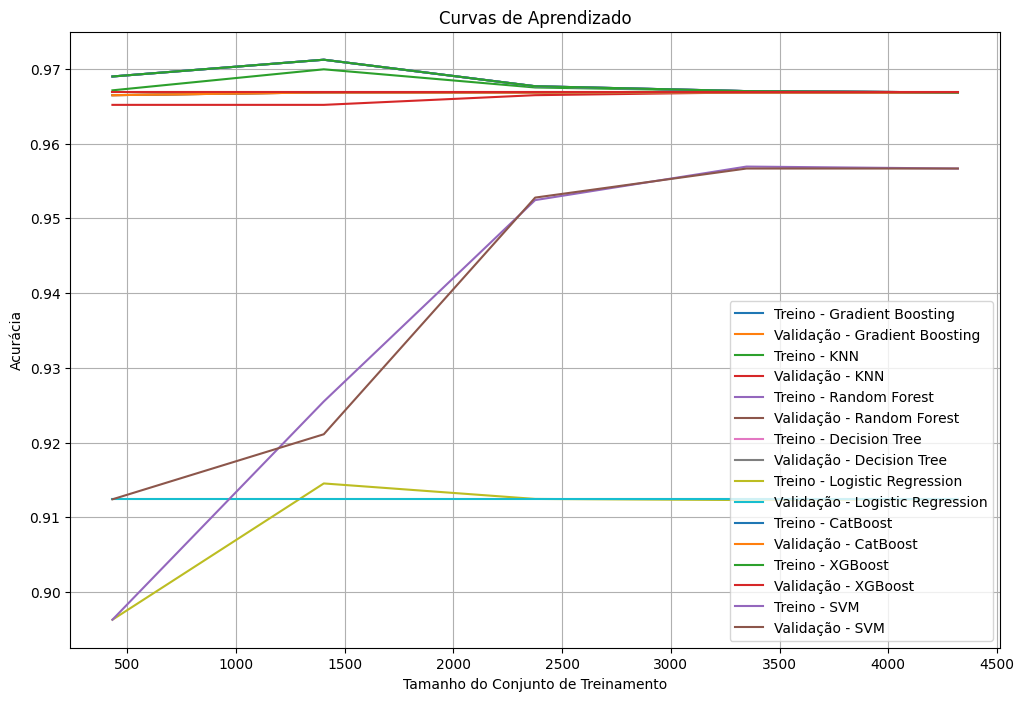

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Função para gerar curvas de aprendizado para vários modelos
def plot_learning_curves(models, model_names, X, y):
    plt.figure(figsize=(12, 8))
    for model, name in zip(models, model_names):
        # Calculando as curvas de aprendizado
        train_sizes, train_scores, val_scores = learning_curve(
            model, X, y, cv=5, scoring='accuracy', n_jobs=-1
        )
        train_mean = np.mean(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)

        # Plotando as curvas
        plt.plot(train_sizes, train_mean, label=f'Treino - {name}')
        plt.plot(train_sizes, val_mean, label=f'Validação - {name}')

    plt.xlabel('Tamanho do Conjunto de Treinamento')
    plt.ylabel('Acurácia')
    plt.title('Curvas de Aprendizado')
    plt.legend()
    plt.grid()
    plt.show()

# Lista de modelos e seus nomes
models = [model_gb, model_knn, model_rf, model_tree, model_minmax, model_cb, model_xgb, model_svm]
model_names = ['Gradient Boosting', 'KNN', 'Random Forest', 'Decision Tree',
               'Logistic Regression', 'CatBoost', 'XGBoost', 'SVM']

# Chamando a função para gerar e plotar as curvas
plot_learning_curves(models, model_names, X_train_scaled, y_train)


In [ ]:
pip install statsmodels --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 16.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Dados das métricas para cada modelo
data = {
    'Modelo': [
        'Logistic Regression', 'Logistic Regression', 'Logistic Regression',
        'Random Forest', 'Random Forest', 'Random Forest',
        'Decision Tree', 'Decision Tree', 'Decision Tree',
        'Gradient Boosting', 'Gradient Boosting', 'Gradient Boosting',
        'KNN', 'KNN', 'KNN',
        'SVM', 'SVM', 'SVM',
        'XGBoost', 'XGBoost', 'XGBoost',
        'CatBoost', 'CatBoost', 'CatBoost',
    ],
    'Métrica': [
        'Acurácia', 'Precisão', 'F1-Score',
        'Acurácia', 'Precisão', 'F1-Score',
        'Acurácia', 'Precisão', 'F1-Score',
        'Acurácia', 'Precisão', 'F1-Score',
        'Acurácia', 'Precisão', 'F1-Score',
        'Acurácia', 'Precisão', 'F1-Score',
        'Acurácia', 'Precisão', 'F1-Score',
        'Acurácia', 'Precisão', 'F1-Score'  # Adicionei para ajustar o comprimento
    ],
    'Valor': [
        0.9090333333333333, 0.8288666666666667, 0.9064333333333333,  # Logistic
        0.966367,  0.929133,  0.963267,  # Random Forest
        0.966367,  0.929133,  0.963267,  # Decision
        0.966367,  0.929133,  0.963267,  # Gradient Boosting
        0.959067,  0.915067,  0.955633, # KNN
        0.966367,  0.929133,  0.963267,  # SVM
        0.966367,  0.929133,  0.963267,  # XGBoost
        0.966367,  0.929133,  0.963267,   # CatBoost
    ]
}

# Criando o DataFrame
df = pd.DataFrame(data)

# Verificando o DataFrame
print(df)


                 Modelo   Métrica     Valor
0   Logistic Regression  Acurácia  0.909033
1   Logistic Regression  Precisão  0.828867
2   Logistic Regression  F1-Score  0.906433
3         Random Forest  Acurácia  0.966367
4         Random Forest  Precisão  0.929133
5         Random Forest  F1-Score  0.963267
6         Decision Tree  Acurácia  0.966367
7         Decision Tree  Precisão  0.929133
8         Decision Tree  F1-Score  0.963267
9     Gradient Boosting  Acurácia  0.966367
10    Gradient Boosting  Precisão  0.929133
11    Gradient Boosting  F1-Score  0.963267
12                  KNN  Acurácia  0.959067
13                  KNN  Precisão  0.915067
14                  KNN  F1-Score  0.955633
15                  SVM  Acurácia  0.966367
16                  SVM  Precisão  0.929133
17                  SVM  F1-Score  0.963267
18              XGBoost  Acurácia  0.966367
19              XGBoost  Precisão  0.929133
20              XGBoost  F1-Score  0.963267
21             CatBoost  Acuráci

<ipython-input-8-605b3ecb10ae>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rankings = df.groupby('Métrica').apply(lambda x: x.sort_values(by='Valor', ascending=False).reset_index(drop=True))


             Métrica               Modelo     Valor
Métrica                                            
Acurácia 0  Acurácia        Random Forest  0.966367
         1  Acurácia        Decision Tree  0.966367
         2  Acurácia    Gradient Boosting  0.966367
         3  Acurácia                  SVM  0.966367
         4  Acurácia             CatBoost  0.966367
         5  Acurácia              XGBoost  0.966367
         6  Acurácia                  KNN  0.959067
         7  Acurácia  Logistic Regression  0.909033
F1-Score 0  F1-Score        Random Forest  0.963267
         1  F1-Score        Decision Tree  0.963267
         2  F1-Score    Gradient Boosting  0.963267
         3  F1-Score                  SVM  0.963267
         4  F1-Score             CatBoost  0.963267
         5  F1-Score              XGBoost  0.963267
         6  F1-Score                  KNN  0.955633
         7  F1-Score  Logistic Regression  0.906433
Precisão 0  Precisão        Random Forest  0.929133
         1  

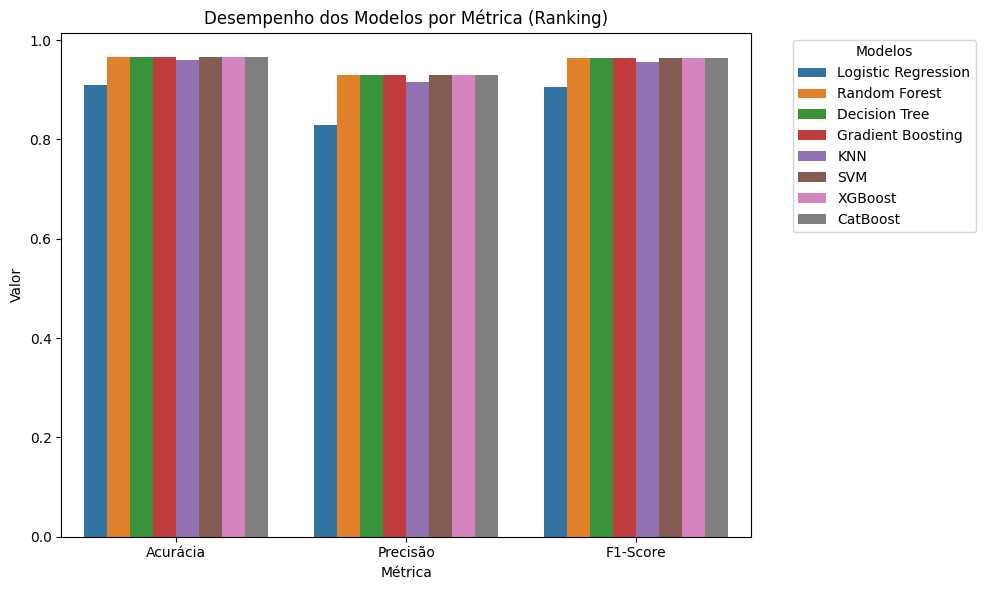

In [ ]:
# Criar ranking dos modelos por métrica
rankings = df.groupby('Métrica').apply(lambda x: x.sort_values(by='Valor', ascending=False).reset_index(drop=True))
rankings = rankings[['Métrica', 'Modelo', 'Valor']]

# Exibir rankings
print(rankings)

# Gráfico de barras do ranking
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Métrica', y='Valor', hue='Modelo')
plt.title("Desempenho dos Modelos por Métrica (Ranking)")
plt.ylabel("Valor")
plt.xlabel("Métrica")
plt.legend(title="Modelos", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


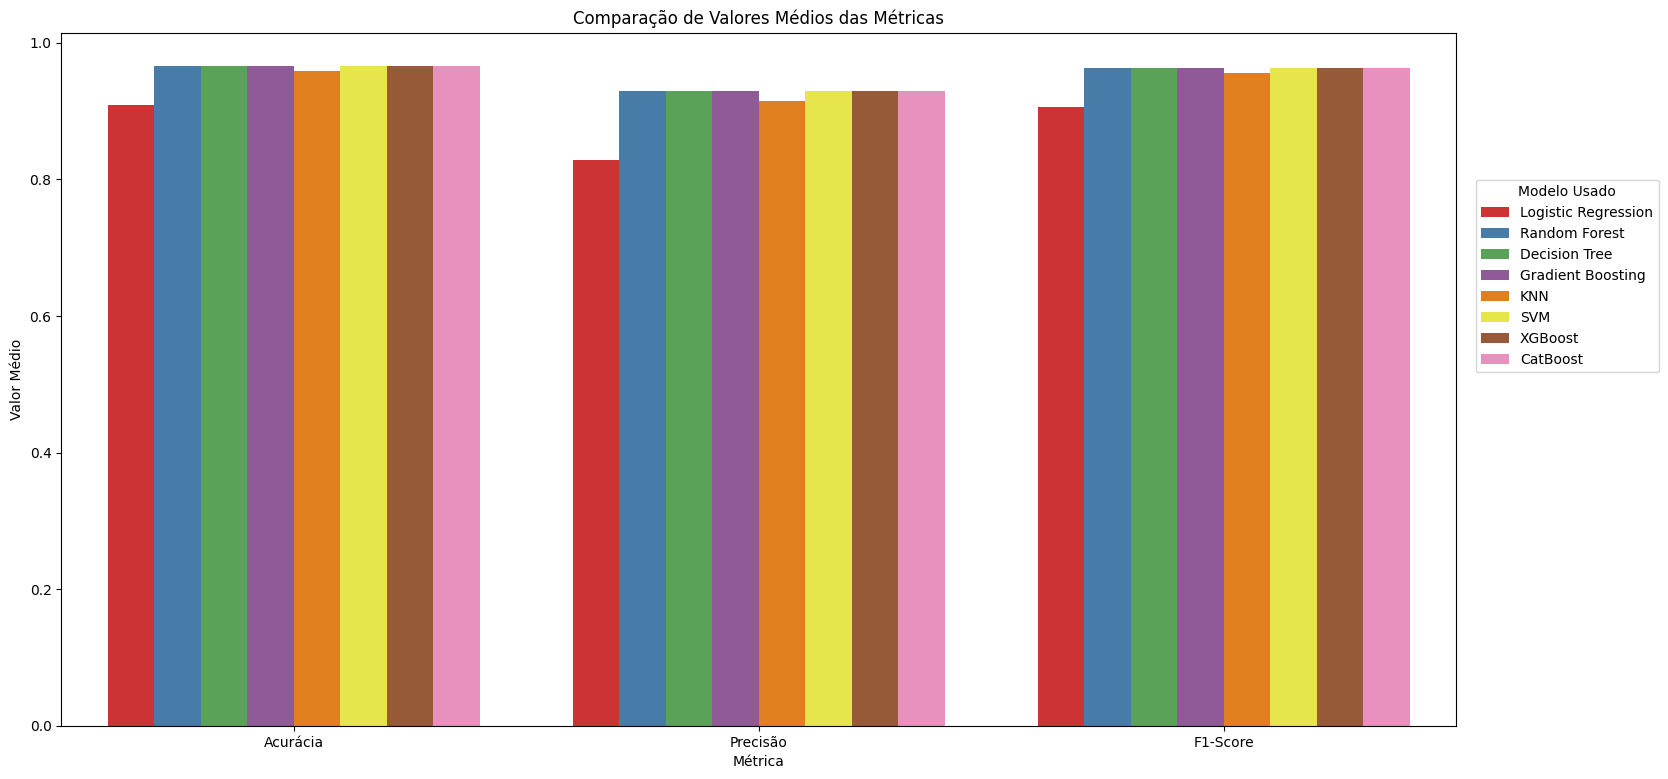

In [ ]:
plt.figure(figsize=(18, 9))
sns.barplot(data=df, x="Métrica", y="Valor", hue="Modelo", errorbar=None, palette="Set1")
plt.title("Comparação de Valores Médios das Métricas")
plt.ylabel("Valor Médio")
plt.xlabel("Métrica")
plt.legend(loc="lower right", bbox_to_anchor=(1.15, 0.5), title="Modelo Usado")
plt.show()


In [ ]:
import pandas as pd

# Definir os dados da tabela em um dicionário
data = {
    "Algoritmo": ["Logistic Regression", "Logistic Regression", "Logistic Regression",
                  "Random Forest", "Random Forest", "Random Forest",
                  "Decision Tree", "Decision Tree", "Decision Tree",
                  "Gradient Boosting", "Gradient Boosting", "Gradient Boosting",
                  "K-Nearest Neighbors", "K-Nearest Neighbors", "K-Nearest Neighbors",
                  "SVM", "SVM", "SVM",
                  "XGBoost", "XGBoost", "XGBoost",
                  "CatBoost", "CatBoost", "CatBoost"],
    "Conjunto": ["Treino", "Validação", "Teste",
                 "Treino", "Validação", "Teste",
                 "Treino", "Validação", "Teste",
                 "Treino", "Validação", "Teste",
                 "Treino", "Validação", "Teste",
                 "Treino", "Validação", "Teste",
                 "Treino", "Validação", "Teste",
                 "Treino", "Validação", "Teste"],
    "Acurácia": [0.9115, 0.9117, 0.9039, 0.9663, 0.9700, 0.9628, 0.9663, 0.9700, 0.9628,
                  0.9663, 0.9700, 0.9628, 0.9606, 0.9622, 0.9544, 0.9663, 0.9700, 0.9628,
                  0.9663, 0.9700, 0.9628, 0.9663, 0.9700, 0.9628],
    "Precisão": [0.8356, 0.8301, 0.8209, 0.9303, 0.9350, 0.9221, 0.9303, 0.9350, 0.9221,
                 0.9303, 0.9350, 0.9221, 0.9194, 0.9195, 0.9063, 0.9303, 0.9350, 0.9221,
                 0.9303, 0.9350, 0.9221, 0.9303, 0.9350, 0.9221],
    "Recall": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    "F1-Score": [0.9105, 0.9072, 0.9016, 0.9639, 0.9664, 0.9595, 0.9639, 0.9664, 0.9595,
                 0.9639, 0.9664, 0.9595, 0.9580, 0.9581, 0.9508, 0.9639, 0.9664, 0.9595,
                 0.9639, 0.9664, 0.9595, 0.9639, 0.9664, 0.9595],
    "AUC-ROC": [0.9694, 0.9736, 0.9667, 0.9694, 0.9736, 0.9667, 0.9694, 0.9736, 0.9667,
                0.9694, 0.9736, 0.9667, 0.9694, 0.9736, 0.9667, 0.9694, 0.9736, 0.9667,
                0.9694, 0.9736, 0.9667, 0.9694, 0.9736, 0.9667]
}

# Criar o DataFrame
df = pd.DataFrame(data)

# Agrupar por algoritmo e calcular a média das métricas (Acurácia, Precisão, F1-Score, AUC-ROC)
df_avg = df.groupby('Algoritmo')[['Acurácia', 'Precisão', 'F1-Score', 'AUC-ROC']].mean()

# Exibir as médias
print(df_avg)


                     Acurácia  Precisão  F1-Score  AUC-ROC
Algoritmo                                                 
CatBoost             0.966367  0.929133  0.963267   0.9699
Decision Tree        0.966367  0.929133  0.963267   0.9699
Gradient Boosting    0.966367  0.929133  0.963267   0.9699
K-Nearest Neighbors  0.959067  0.915067  0.955633   0.9699
Logistic Regression  0.909033  0.828867  0.906433   0.9699
Random Forest        0.966367  0.929133  0.963267   0.9699
SVM                  0.966367  0.929133  0.963267   0.9699
XGBoost              0.966367  0.929133  0.963267   0.9699


<ipython-input-14-47817db6004c>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_auc_roc, x='Modelo', y='AUC-ROC Média', palette='viridis')


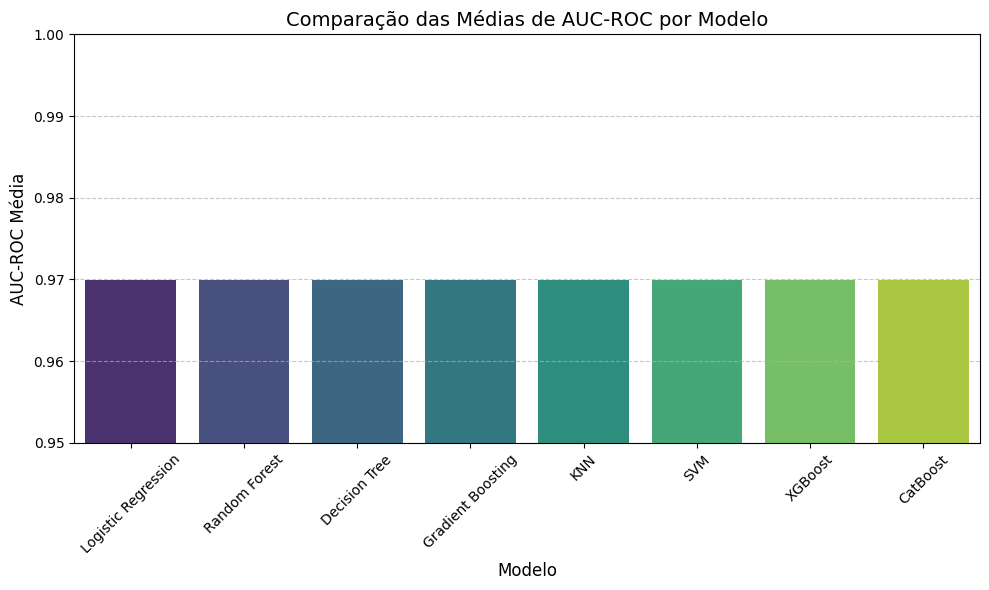

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Valores médios de AUC-ROC para cada modelo
auc_roc_values = {
    'Modelo': [
        'Logistic Regression', 'Random Forest', 'Decision Tree',
        'Gradient Boosting', 'KNN','SVM', 'XGBoost', 'CatBoost'
    ],
    'AUC-ROC Média': [0.9699, 0.9699, 0.9699, 0.9699, 0.9699, 0.9699, 0.9699, 0.9699]
}

# Criar um DataFrame para facilitar o uso
df_auc_roc = pd.DataFrame(auc_roc_values)

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=df_auc_roc, x='Modelo', y='AUC-ROC Média', palette='viridis')

# Personalizar o gráfico
plt.title('Comparação das Médias de AUC-ROC por Modelo', fontsize=14)
plt.ylabel('AUC-ROC Média', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.ylim(0.95, 1.0)  # Ajustar o eixo Y para focar nas diferenças
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar o gráfico
plt.tight_layout()
plt.show()
